In [1]:
from io import open
import numpy as np

In [164]:
%matplotlib inline 
import matplotlib.pyplot as plt

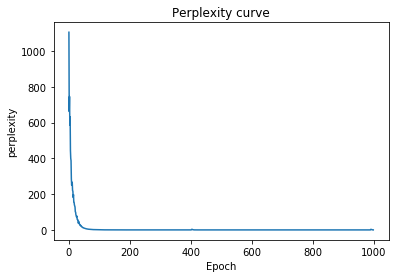

In [166]:
plt.plot(perplexities)
plt.xlabel('Epoch')
plt.ylabel('perplexity')
plt.title('Perplexity curve')

In [186]:
#测试诗句生成
for i in xrange(3):
    start_word = lang.get_word(random.randint(0, len(lang.word2index)))
    randomDemo(model, lang, start_word)
    print 

偃露吹苍马路扫，天尘今太红。

要自花夫亦将，荒与川浸溜。是节东篱菊，纷披为谁秀。自壮几时开，新声子夜歌。

衢所天上今上在，独丸日月十经秋。秋来未曾馀力，君人清再欢间。



由于训练样本也比较小，所以生成的句子效果不算太好。

In [2]:
lines = open('poemFromTang.txt', encoding='utf-8').readlines()

In [3]:
class Lang:
    def __init__(self):
        self.word2index = {'<pad>':0, '<s>':1, '</s>':2, '<unknown>':3}
        self.index2word = {v:k for k,v in self.word2index.iteritems()}
        self.n_words = len(self.word2index)
    def addChineseSentence(self, sentence):
        sentence = sentence.strip()
        for word in sentence:
            self.addChineseWord(word)
            
    def addChineseWord(self, word):
        if not self.word2index.has_key(word):
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1
    
    def vectorize(self, sentence):
        sentence = sentence.strip()
        nums = []
        for char in sentence:
            if self.word2index.has_key(char):
                nums.append(self.word2index[char])
            else:
                nums.append(self.word2index['<unknown>'])
        return nums
    def get_index(self, word):
        if self.word2index.has_key(word):
            return self.word2index[word]
        else:
            return self.word2index['<unknown>']
    def get_word(self, index):
        return self.index2word[index]

In [4]:
poems = [] #每一个元素是一首诗词
poem = ''
for line in lines:
    if line=='\n':
        if len(poem)>0:
            poems.append(poem)
        poem = ''
    else:
        poem += line.strip()

In [41]:
from collections import Counter

Counter(map(len, poems))

Counter({16: 1,
         24: 2,
         32: 22,
         33: 1,
         48: 69,
         56: 2,
         58: 1,
         59: 1,
         64: 13,
         70: 1,
         72: 2,
         74: 1,
         80: 3,
         81: 1,
         83: 1,
         88: 1,
         92: 1,
         93: 1,
         96: 1,
         101: 1,
         104: 1,
         105: 1,
         120: 1,
         128: 2,
         129: 1,
         132: 3,
         135: 1,
         144: 2,
         148: 1,
         152: 1,
         156: 1,
         160: 2,
         161: 1,
         166: 1,
         168: 1,
         192: 1,
         204: 1,
         216: 1,
         224: 1,
         244: 1,
         258: 1,
         282: 1,
         288: 2,
         312: 1,
         320: 2,
         336: 1,
         407: 1,
         600: 1,
         892: 1,
         1107: 1})

有一些诗比较长。本来可以直接丢弃这部分数据，但考虑到本来数据已经不太足够，这里讲数字超过的诗拆分为长度小于74的集合。拆分的原则是，使得长于74的诗，分为多部分，每部分长度接近48。

In [60]:
new_poems = []

for poem in poems:
    if len(poem)<74:
        new_poems.append(poem)
    else:
        phrases = poem.split('。'.decode('utf-8'))
        poem = ''
        for ph in phrases:
            if len(poem) + len(ph)>48:
                new_poems.append(poem.strip())
                poem = ph + '。'.decode('utf-8')
            else:
                poem += ph + '。'.decode('utf-8')
        if len(poem)>=16:
            new_poems.append(poem.strip())
            
train_Xs = []

for poem in new_poems:
    nums = lang.vectorize(poem)
    train_Xs.append(nums)

In [155]:
import torch.nn as nn
import torch as T
from torch.autograd import Variable
import torch.nn.functional as F
import random
from torch import optim
from torch.optim.lr_scheduler import StepLR

USE_CUDA = T.cuda.is_available()

FloatTensor = T.cuda.FloatTensor if USE_CUDA else T.FloatTensor
LongTensor = T.cuda.LongTensor if USE_CUDA else T.LongTensor

In [104]:
class PoemLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers):
        super(PoemLSTM, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding_dim = embedding_dim
        
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, num_layers=n_layers)
        
        self.fc = nn.Linear(hidden_size, vocab_size)
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.xavier_uniform(self.embedding.state_dict()['weight'])
        nn.init.xavier_uniform(self.fc.state_dict()['weight'])
        
    def init_hidden(self, batch_size):
        hidden = Variable(T.zeros(self.n_layers,batch_size, self.hidden_size).type(FloatTensor))
        c = Variable(T.zeros(self.n_layers, batch_size, self.hidden_size).type(FloatTensor))
        hiddens = (hidden, c)
        return hiddens
        
    def forward(self, x, seq_len, hiddens):
        """
        x: B x L
        """
        batch_size = x.size(0)
        length = x.size(1)
        x = self.embedding(x).view(batch_size, -1, self.embedding_dim)  #1 x L x D
        pack = nn.utils.rnn.pack_padded_sequence(x, seq_len, batch_first=True)
        output, hiddens = self.lstm(pack, hiddens)
        output,  _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
        output = self.fc(output.contiguous().view(-1, self.hidden_size))
        return F.log_softmax(output), hiddens

In [136]:
def get_batch(Xs, batch_size=32):
    Xs = np.copy(Xs)
    random.shuffle(Xs)
    sindex = 0
    eindex = batch_size
    while eindex<len(Xs):
        batch = Xs[sindex:eindex]
        batch = [[1]+b+[2] for b in batch]
        batch = sorted(batch, key=lambda x:len(x), reverse=True)
        max_len = len(batch[0])
        X = []
        y = []
        seq_len = []
        for b in batch:
            seq_len.append(len(b))
            while len(b)<max_len:
                b.append(0)
            X.append(b[:-1])
            y.append(b[1:])
        yield X, y, seq_len
        sindex = eindex
        eindex += batch_size
    if sindex<len(Xs):
        batch = Xs[sindex:]
        batch = [[1]+b+[2] for b in batch]
        batch = sorted(batch, key=lambda x:len(x), reverse=True)
        max_len = len(batch[0])
        X = []
        y = []
        seq_len = []
        for b in batch:
            seq_len.append(len(b))
            while len(b)<max_len:
                b.append(0)
            X.append(b[:-1])
            y.append(b[1:])
        yield X, y, seq_len 

In [132]:
for Xs, ys, seq_len in get_batch(train_Xs[:10], 2):
    print Xs, ys, seq_len
    for i in Xs[0]:
        print lang.get_word(i),
    break

[[1, 154, 102, 183, 184, 185, 61, 186, 10, 187, 188, 189, 190, 191, 192, 117, 18, 91, 102, 193, 194, 195, 69, 196, 10, 71, 189, 197, 61, 198, 9, 169, 18, 199, 200, 201, 202, 203, 127, 204, 10, 205, 185, 107, 206, 56, 207, 208, 18], [1, 255, 122, 256, 10, 71, 189, 257, 10, 258, 259, 137, 260, 261, 262, 214, 10, 216, 263, 264, 133, 63, 114, 265, 18, 18, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] [[154, 102, 183, 184, 185, 61, 186, 10, 187, 188, 189, 190, 191, 192, 117, 18, 91, 102, 193, 194, 195, 69, 196, 10, 71, 189, 197, 61, 198, 9, 169, 18, 199, 200, 201, 202, 203, 127, 204, 10, 205, 185, 107, 206, 56, 207, 208, 18, 2], [255, 122, 256, 10, 71, 189, 257, 10, 258, 259, 137, 260, 261, 262, 214, 10, 216, 263, 264, 133, 63, 114, 265, 18, 18, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]] [50, 27]
<s> 人 生 得 意 须 尽 欢 ， 莫 使 金 尊 空 对 月 。 天 生 我 材 必 有 用 ， 千 金 散 尽 还 复 来 。 烹 羊 宰 牛 且 为 乐 ， 会 须 一 饮 三 百 杯 。


In [156]:
def trainIter(model, Xs, optimizer, criterion, scheduler=None, num_epochs=20, print_every=50, batch_size=32):
    perplexities = []
    for epoch in xrange(num_epochs):
        print '-' * 10
        epoch_loss = 0.0
        counter = 0
        x_counter = 0
        perplex = 0.0
        for X, y, seq_len in get_batch(Xs, batch_size):
            perplexity = 0.0
            X = Variable(LongTensor(X))
            y = Variable(LongTensor(y).view(-1))

            hiddens = model.init_hidden(X.size(0))

            loss = 0.0
            
            output, _ = model(X, seq_len, hiddens)
            loss = criterion(output, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.data[0]
            counter += 1
            x_counter += sum(seq_len) 
            perplex += loss.data[0]*y.size(0)
        if scheduler!=None:
            scheduler.step()

        perplexities.append(np.power(2, perplex / x_counter))
        print '[{}/{}] loss:{:.4f} perplex:{:.2f}'.format(epoch + 1, num_epochs, epoch_loss / counter,
                                                          perplexities[-1])
    return perplexities


def randomDemo(model, lang, start_word='<s>'):
    input = Variable(LongTensor([lang.get_index(start_word)]), volatile=True)
    words = []
    if start_word!='<s>':
        words.append(start_word)
    hiddens = model.init_hidden(1)
    idx = 0
    while idx<48:
        output, hiddens = model(input.view(1,1), [1],hiddens)
        predict = output.data.cpu().max(1)[1][0]
        if predict==2:
            break
        words.append(lang.get_word(predict))
        input = Variable(LongTensor([predict]), volatile=True)
        idx += 1
        
    print "".join(words)

In [157]:
embed_size = 50
hidden_size = 128

model = PoemLSTM(lang.n_words, embed_size, hidden_size, 2)
if USE_CUDA:
    model.cuda()
    
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=200, gamma=0.9)
criterion = nn.NLLLoss()

In [158]:
perplexities = trainIter(model, train_Xs, optimizer, criterion, scheduler, num_epochs=1000, print_every=200, batch_size=32)

----------
[1/1000] loss:7.3204 perplex:1104.54
----------
[2/1000] loss:6.8972 perplex:662.04
----------
[3/1000] loss:6.8203 perplex:745.82
----------
[4/1000] loss:6.7315 perplex:585.34
----------
[5/1000] loss:6.6463 perplex:632.48
----------
[6/1000] loss:6.4941 perplex:444.19
----------
[7/1000] loss:6.3972 perplex:400.29
----------
[8/1000] loss:6.3028 perplex:387.33
----------
[9/1000] loss:6.1898 perplex:286.76
----------
[10/1000] loss:6.1070 perplex:250.95
----------
[11/1000] loss:6.0011 perplex:268.25
----------
[12/1000] loss:5.8969 perplex:262.90
----------
[13/1000] loss:5.7745 perplex:220.46
----------
[14/1000] loss:5.6732 perplex:217.78
----------
[15/1000] loss:5.5741 perplex:182.80
----------
[16/1000] loss:5.4801 perplex:198.00
----------
[17/1000] loss:5.3805 perplex:155.82
----------
[18/1000] loss:5.2965 perplex:155.02
----------
[19/1000] loss:5.2041 perplex:140.98
----------
[20/1000] loss:5.1178 perplex:133.58
----------
[21/1000] loss:5.0310 perplex:128.92


[176/1000] loss:0.1699 perplex:1.18
----------
[177/1000] loss:0.1645 perplex:1.17
----------
[178/1000] loss:0.1575 perplex:1.16
----------
[179/1000] loss:0.1547 perplex:1.16
----------
[180/1000] loss:0.1551 perplex:1.16
----------
[181/1000] loss:0.1538 perplex:1.15
----------
[182/1000] loss:0.1481 perplex:1.15
----------
[183/1000] loss:0.1512 perplex:1.15
----------
[184/1000] loss:0.1435 perplex:1.15
----------
[185/1000] loss:0.1476 perplex:1.14
----------
[186/1000] loss:0.1444 perplex:1.14
----------
[187/1000] loss:0.1410 perplex:1.14
----------
[188/1000] loss:0.1391 perplex:1.14
----------
[189/1000] loss:0.1383 perplex:1.14
----------
[190/1000] loss:0.1370 perplex:1.14
----------
[191/1000] loss:0.1358 perplex:1.14
----------
[192/1000] loss:0.1355 perplex:1.14
----------
[193/1000] loss:0.1383 perplex:1.13
----------
[194/1000] loss:0.1365 perplex:1.13
----------
[195/1000] loss:0.1332 perplex:1.13
----------
[196/1000] loss:0.1342 perplex:1.13
----------
[197/1000] lo

[351/1000] loss:0.0997 perplex:1.10
----------
[352/1000] loss:0.1033 perplex:1.10
----------
[353/1000] loss:0.1031 perplex:1.10
----------
[354/1000] loss:0.0995 perplex:1.10
----------
[355/1000] loss:0.1019 perplex:1.10
----------
[356/1000] loss:0.1020 perplex:1.10
----------
[357/1000] loss:0.1017 perplex:1.10
----------
[358/1000] loss:0.0988 perplex:1.10
----------
[359/1000] loss:0.1039 perplex:1.10
----------
[360/1000] loss:0.1037 perplex:1.10
----------
[361/1000] loss:0.1031 perplex:1.10
----------
[362/1000] loss:0.1018 perplex:1.10
----------
[363/1000] loss:0.0966 perplex:1.10
----------
[364/1000] loss:0.0984 perplex:1.10
----------
[365/1000] loss:0.1019 perplex:1.10
----------
[366/1000] loss:0.1070 perplex:1.10
----------
[367/1000] loss:0.1056 perplex:1.10
----------
[368/1000] loss:0.1025 perplex:1.10
----------
[369/1000] loss:0.1010 perplex:1.10
----------
[370/1000] loss:0.1015 perplex:1.10
----------
[371/1000] loss:0.1028 perplex:1.10
----------
[372/1000] lo

[526/1000] loss:0.0979 perplex:1.10
----------
[527/1000] loss:0.0998 perplex:1.10
----------
[528/1000] loss:0.1013 perplex:1.10
----------
[529/1000] loss:0.0951 perplex:1.10
----------
[530/1000] loss:0.0971 perplex:1.10
----------
[531/1000] loss:0.1002 perplex:1.10
----------
[532/1000] loss:0.1061 perplex:1.10
----------
[533/1000] loss:0.0988 perplex:1.10
----------
[534/1000] loss:0.0979 perplex:1.10
----------
[535/1000] loss:0.0977 perplex:1.10
----------
[536/1000] loss:0.1008 perplex:1.10
----------
[537/1000] loss:0.0983 perplex:1.10
----------
[538/1000] loss:0.1018 perplex:1.10
----------
[539/1000] loss:0.1026 perplex:1.10
----------
[540/1000] loss:0.0969 perplex:1.10
----------
[541/1000] loss:0.0992 perplex:1.10
----------
[542/1000] loss:0.1003 perplex:1.10
----------
[543/1000] loss:0.0949 perplex:1.10
----------
[544/1000] loss:0.0950 perplex:1.10
----------
[545/1000] loss:0.1013 perplex:1.10
----------
[546/1000] loss:0.1001 perplex:1.10
----------
[547/1000] lo

[701/1000] loss:0.0997 perplex:1.09
----------
[702/1000] loss:0.0910 perplex:1.09
----------
[703/1000] loss:0.0964 perplex:1.09
----------
[704/1000] loss:0.1002 perplex:1.09
----------
[705/1000] loss:0.0980 perplex:1.09
----------
[706/1000] loss:0.0959 perplex:1.09
----------
[707/1000] loss:0.0936 perplex:1.09
----------
[708/1000] loss:0.0935 perplex:1.09
----------
[709/1000] loss:0.0916 perplex:1.09
----------
[710/1000] loss:0.0986 perplex:1.09
----------
[711/1000] loss:0.0970 perplex:1.09
----------
[712/1000] loss:0.0990 perplex:1.09
----------
[713/1000] loss:0.0944 perplex:1.09
----------
[714/1000] loss:0.0974 perplex:1.09
----------
[715/1000] loss:0.0960 perplex:1.09
----------
[716/1000] loss:0.0953 perplex:1.09
----------
[717/1000] loss:0.0961 perplex:1.09
----------
[718/1000] loss:0.0992 perplex:1.09
----------
[719/1000] loss:0.0970 perplex:1.09
----------
[720/1000] loss:0.0996 perplex:1.09
----------
[721/1000] loss:0.0957 perplex:1.09
----------
[722/1000] lo

[876/1000] loss:0.0977 perplex:1.09
----------
[877/1000] loss:0.0987 perplex:1.09
----------
[878/1000] loss:0.0938 perplex:1.09
----------
[879/1000] loss:0.0950 perplex:1.09
----------
[880/1000] loss:0.0960 perplex:1.09
----------
[881/1000] loss:0.0934 perplex:1.09
----------
[882/1000] loss:0.0930 perplex:1.09
----------
[883/1000] loss:0.0898 perplex:1.09
----------
[884/1000] loss:0.0905 perplex:1.09
----------
[885/1000] loss:0.0958 perplex:1.09
----------
[886/1000] loss:0.0977 perplex:1.09
----------
[887/1000] loss:0.0933 perplex:1.09
----------
[888/1000] loss:0.0947 perplex:1.09
----------
[889/1000] loss:0.0973 perplex:1.09
----------
[890/1000] loss:0.0978 perplex:1.09
----------
[891/1000] loss:0.0986 perplex:1.09
----------
[892/1000] loss:0.0949 perplex:1.09
----------
[893/1000] loss:0.0961 perplex:1.09
----------
[894/1000] loss:0.0964 perplex:1.09
----------
[895/1000] loss:0.0975 perplex:1.09
----------
[896/1000] loss:0.0967 perplex:1.09
----------
[897/1000] lo

In [162]:
randomDemo(model, lang, '谁'.decode('utf-8'))

谁人国临天，俱门醉嗟侯客。君来必知宴颜成，相草弦入茫茫。
